The RMSE metric on the test set should not be more than 48.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

**DATA PREPROCESSING**

In [2]:
df = pd.read_csv('taxi.csv', index_col = 'datetime', parse_dates = ['datetime'])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df = df.resample('1H').sum()

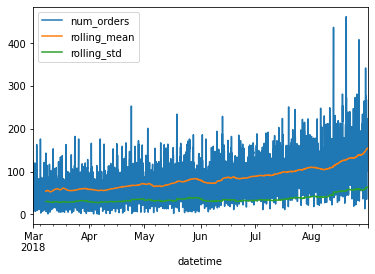

In [5]:
def get_graphs(df):
    df['rolling_mean'] = df['num_orders'].rolling(168).mean()
    df['rolling_std'] = df['num_orders'].rolling(168).std()
    df.plot()
    plt.show()
    
get_graphs(df)

In [6]:
decomposed = seasonal_decompose(df['num_orders'])

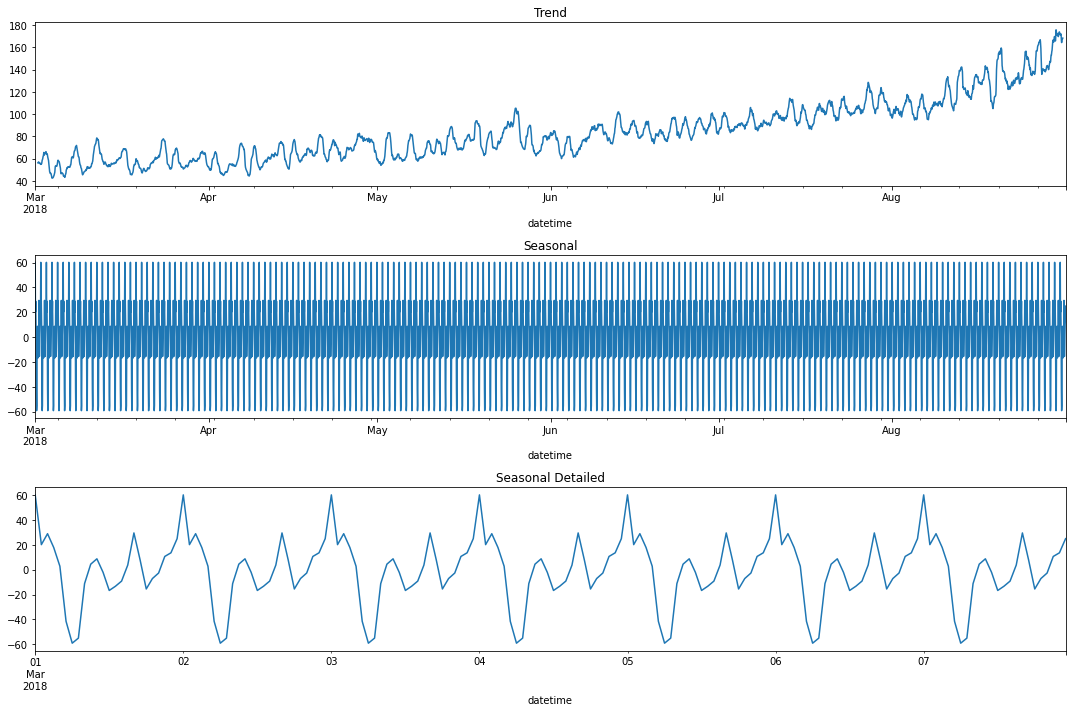

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)  
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(3, 1, 2)  
decomposed.seasonal.plot()
plt.title('Seasonal')
plt.subplot(3, 1, 3)  
decomposed.seasonal[0:168].plot()
plt.title('Seasonal Detailed')
plt.tight_layout()
plt.show()

In [8]:
 df['num_orders'].is_monotonic_increasing

False

**FEATURE ENGINEERING**

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean_shift'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, 50, 3)

**PREDICTION**

**Spliting**

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


**Mean and previous check**

In [17]:
pred_mean = np.ones(len(target_test))*target_test.mean()
print(f'RMSE with mean for train: {round(mean_squared_error(target_test, pred_mean)**0.5, 3)}')

RMSE with mean for train: 54.635


In [18]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print(f'RMSE with previous for test: {round(mean_squared_error(target_test, pred_previous)**0.5, 3)}')

RMSE with previous for test: 53.368


**Linear regression**

In [13]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print('RMSE for the training set:', round(mean_squared_error(target_train, pred_train)**0.5, 3))
print('RMSE for the test set:', round(mean_squared_error(target_test, pred_test)**0.5, 3))

RMSE for the training set: 22.262
RMSE for the test set: 37.874


**LGBMRegressor** 

In [14]:
from lightgbm import LGBMRegressor 
model_lgmb = LGBMRegressor()
model_lgmb.fit(train.drop('num_orders', axis=1),train['num_orders'])
pred_train = model_lgmb.predict(train.drop('num_orders', axis=1))
pred_test = model_lgmb.predict(test.drop('num_orders', axis=1))

print(f"RMSE for train: {round(mean_squared_error(target_train, pred_train)**0.5, 3)}")
print(f"RMSE for test: {round(mean_squared_error(target_test, pred_test)**0.5, 3)}")

RMSE for train: 9.411
RMSE for test: 40.122


In [21]:
params_lgbm = {   
     'num_leaves': [7, 12, 15],
     'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5]
}

model = LGBMRegressor()
cv = TimeSeriesSplit()
grid_search_lgbm = GridSearchCV(model, param_grid=params_lgbm, cv = cv, verbose=10) 
grid_search_lgbm.fit(features_train, target_train)

#view grid_search_best params
print (grid_search_lgbm.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, n_estimators=50, num_leaves=7..........
[CV 1/5; 1/27] END learning_rate=0.01, n_estimators=50, num_leaves=7; total time=   0.0s
[CV 2/5; 1/27] START learning_rate=0.01, n_estimators=50, num_leaves=7..........
[CV 2/5; 1/27] END learning_rate=0.01, n_estimators=50, num_leaves=7; total time=   0.0s
[CV 3/5; 1/27] START learning_rate=0.01, n_estimators=50, num_leaves=7..........
[CV 3/5; 1/27] END learning_rate=0.01, n_estimators=50, num_leaves=7; total time=   0.0s
[CV 4/5; 1/27] START learning_rate=0.01, n_estimators=50, num_leaves=7..........
[CV 4/5; 1/27] END learning_rate=0.01, n_estimators=50, num_leaves=7; total time=   0.0s
[CV 5/5; 1/27] START learning_rate=0.01, n_estimators=50, num_leaves=7..........
[CV 5/5; 1/27] END learning_rate=0.01, n_estimators=50, num_leaves=7; total time=   0.0s
[CV 1/5; 2/27] START learning_rate=0.01, n_estimators=50, num_leaves=12.........
[CV 1/5

In [20]:
from lightgbm import LGBMRegressor 
model_lgmb = LGBMRegressor(learning_rate = 0.1, n_estimators = 100, num_leaves = 12)
model_lgmb.fit(train.drop('num_orders', axis=1),train['num_orders'])
pred_train = model_lgmb.predict(train.drop('num_orders', axis=1))
pred_test = model_lgmb.predict(test.drop('num_orders', axis=1))

print(f"RMSE for train: {round(mean_squared_error(target_train, pred_train)**0.5, 3)}")
print(f"RMSE for test: {round(mean_squared_error(target_test, pred_test)**0.5, 3)}")

RMSE for train: 15.298
RMSE for test: 41.348
